In [2]:
import dlem
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
DATA_FOLDER ='../../../loopextrusion_data_creation/.data/akita_data_all_resolutions/' 
RES = 10_000
TRAIN_CELL_LINE = 'HFF'

In [4]:
dataset_seqfea = dlem.dataset_dlem.SeqFeatureDataset(DATA_FOLDER)

In [5]:
tmp = dataset_seqfea[1]

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/dlem/dataset_dlem.py:127: RuntimeWarning: invalid value encountered in log1p
  tmp = np.log1p(_standardize(tmp, stats[region["chr"]]))


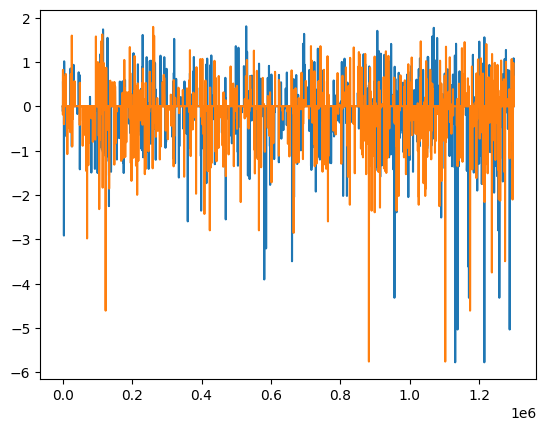

In [6]:
plt.plot(tmp[0])
plt.plot(tmp[1])

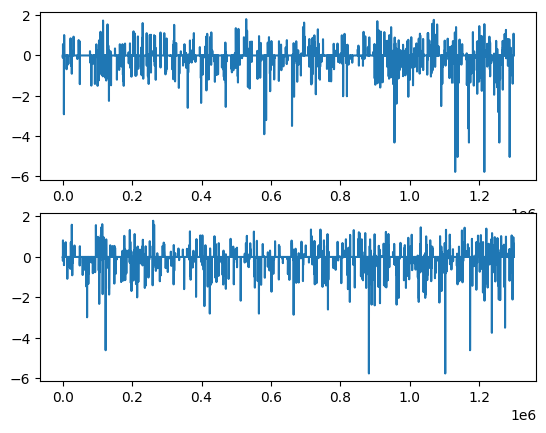

In [7]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(tmp[0])
axes[1].plot(tmp[1])

In [8]:
data_train = dlem.dataset_dlem.CombinedDataset(
    dlem.dataset_dlem.SeqFeatureDataset(DATA_FOLDER),
    dlem.dataset_dlem.ContactmapDataset(DATA_FOLDER, RES, select_cell_lines=[TRAIN_CELL_LINE]),
    dlem.dataset_dlem.TrackDataset(DATA_FOLDER, select_cell_lines=[TRAIN_CELL_LINE]))

In [9]:
data_train[0]

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/dlem/dataset_dlem.py:127: RuntimeWarning: invalid value encountered in log1p
  tmp = np.log1p(_standardize(tmp, stats[region["chr"]]))


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([-0.34735847, -0.26801383, -0.16442579, ..., -0.12865707,
         0.46122754, -0.30831674], dtype=float32),
 array([[-0.29397467, -0.29397467, -0.29397467, ..., -0.01138822,
         -0.01138822, -0.01138822]], dtype=float32))

In [10]:
pooler = dlem.seq_pooler.SequenceFeaturePoolerSimple([3], [RES])

In [11]:
input = torch.from_numpy(np.vstack([data_train[0][0], data_train[0][2]]))

In [12]:
input.shape

torch.Size([3, 1300000])

In [13]:
pooler(input.unsqueeze(0))

tensor([[[-1.0076e-03,  0.0000e+00,  1.1248e-02,  1.9641e-02,  4.5194e-03,
           1.6046e-01,  1.2925e-02, -1.6127e-03,  1.4967e-02,  1.4749e-02,
           6.2770e-02, -3.5060e-04,  4.2900e-02,  0.0000e+00, -1.0550e-03,
           1.2755e-02,  7.1335e-03,  6.8702e-02,  0.0000e+00, -5.1017e-05,
          -4.6142e-04,  6.8905e-04,  4.5689e-05,  1.1489e-02,  0.0000e+00,
          -5.6801e-04,  0.0000e+00,  1.6498e-02,  1.9019e-03, -1.8046e-04,
           0.0000e+00,  5.5373e-03,  4.7661e-02,  8.3620e-03,  0.0000e+00,
           1.1586e-01,  1.8535e-03,  9.2535e-03, -4.1227e-04, -9.6582e-04,
          -3.4790e-04,  2.8116e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          -4.2481e-04, -6.0201e-05, -1.2434e-03,  1.9188e-03,  2.9489e-02,
           0.0000e+00,  2.7000e-02, -7.8295e-04,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  1.0249e-02, -7.4833e-04,  1.1812e-02,
           2.3843e-02,  1.6580e-03,  3.3195e-02, -6.4514e-04,  2.7540e-02,
           2.8621e-02,  6

In [14]:
data_train.start, data_train.stop

(3, 80)

In [15]:
data_train.patch_dim

130

In [16]:
model = dlem.head.ForkedBasePairTrackHead(data_train.patch_dim,
                             1,
                             2,
                             data_train.start,
                             data_train.stop,
                             dlem.util.dlem,
                             pooler,
                             channel_per_route=3,
                             layer_num=4)

In [24]:
dataloader_train = torch.utils.data.DataLoader(data_train,
                                               batch_size = 32,
                                               shuffle=True)

In [25]:
seq, contact, track = next(iter(dataloader_train))

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/dlem/dataset_dlem.py:127: RuntimeWarning: invalid value encountered in log1p
  tmp = np.log1p(_standardize(tmp, stats[region["chr"]]))


In [18]:
model

ForkedBasePairTrackHead(
  (tail): SequenceFeaturePoolerSimple(
    (layer): AttentionPooling1D(
      (softmax): Softmax(dim=-1)
    )
  )
  (feature_batch_norm): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 12, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(9, 9, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(6, 6, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (trans_convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (mixer): Sequential(
    (0): Conv1d(12, 2, kernel_size=(1,), stride=(1,))
    (1): Sigmoid()
  )
  (raw_track_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_ru

In [28]:
model(contact, track, seq, 15).shape

torch.Size([32, 5053])

In [29]:
contact.shape[1] - model(contact, track, seq, 1).shape[1]

127